In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import os
import time
import re

In [2]:
#train_filepaths = glob.glob('../input/cassava-leaf-disease-classification/train_tfrecords/*.tfrec')
train_img_filepaths = np.array( glob.glob('./train_images/*.jpg') )

labels = pd.read_json('./label_num_to_disease_map.json', typ='series')
train_csv = pd.read_csv('./train.csv')
train_csv['image_path'] = ['./train_images/'+str(id_) for id_ in train_csv['image_id']]

labels

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

In [4]:
permutation = np.random.permutation(train_csv.shape[0])
train_csv = train_csv.iloc[permutation]

In [5]:
train_paths = train_csv['image_path'].to_numpy()
train_labels = train_csv['label'].to_numpy()

In [6]:
def unique_percent(labels):
    unique, count = np.unique(labels, return_counts=True)
    class_percent = count/len(labels)

    return np.concatenate((unique, class_percent))

unique_percent(train_labels)

array([0.        , 1.        , 2.        , 3.        , 4.        ,
       0.05080151, 0.10230406, 0.11151096, 0.61494602, 0.12043744])

In [7]:
#input shape expected for EfficientNet
IMAGE_SIZE = [300, 300]
NUM_CLASSES = labels.size
BATCH_SIZE = 16
AUTOTUNE = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()

In [8]:
# img_augmentation = Sequential([
#     preprocessing.RandomFlip(),
#     preprocessing.RandomRotation(factor=0.3),
#     preprocessing.RandomContrast(factor=0.1)
# ], name='img_augmentation')


def decode_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.random_crop(image, [*IMAGE_SIZE, 3])
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image, label


def image_augmentation(image, label):
    
    image = tf.image.flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image, label


def preprocess_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def cassava_dataset(filepaths, labels, batch=BATCH_SIZE, augment=True, labeled=True):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.shuffle(len(filepaths))
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
    if augment:
        dataset = dataset.map(image_augmentation, num_parallel_calls=AUTOTUNE)
    if labeled:
        dataset = dataset.map(preprocess_label, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch)
    return dataset.prefetch(AUTOTUNE)


def test_dataset():
    test_img_filepaths = np.array( glob.glob('../input/cassava-leaf-disease-classification/test_images/*.jpg') )
    labels = [re.search(r"(?<=test_images/).*(.jpg)", path).group(0)
              for path in test_img_filepaths]
    
    dataset = cassava_dataset(test_img_filepaths, labels, augment=False, labeled=False)
    return dataset

# ts = test_dataset()
#ds = cassava_dataset(train_paths, train_labels, batch=1,augment=True)

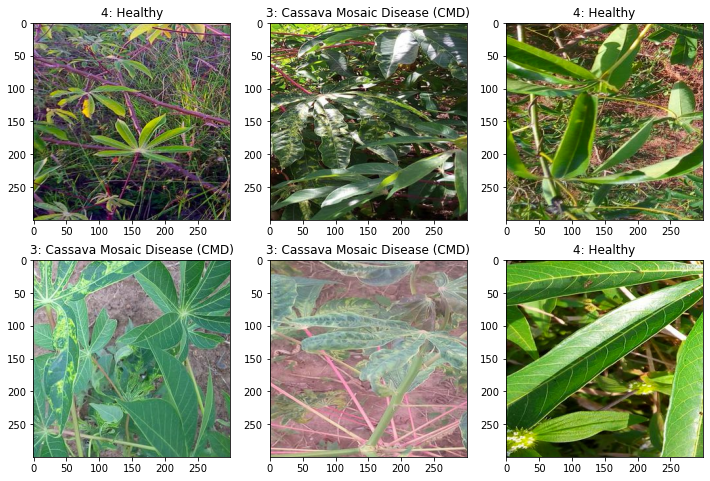

In [10]:
example_ds = cassava_dataset(train_paths, train_labels, batch=1, augment=True)

n_row = 2
n_col = 3

plt.figure(figsize=(n_col*4,n_row*4))

for i, (image, label) in enumerate(example_ds.take(n_col*n_row)):
    image = np.reshape(image.numpy(), (*IMAGE_SIZE, 3))
    label = np.argmax(label.numpy())
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(image)
    plt.title(str(label) + ': ' + (labels[label]))
plt.show()

In [53]:
def build_model():
    inputs = keras.layers.Input(shape=(*IMAGE_SIZE, 3))
    effnet = EfficientNetB3(include_top=False, input_tensor=inputs, weights='imagenet')
    for layer in effnet.layers[:-20]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    
    x = keras.layers.GlobalAveragePooling2D()(effnet.output)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation('relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    
    model = keras.Model(inputs, outputs)
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['categorical_accuracy'])
    
    return model


def unfreeze_model(model):
    # unfreeze
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"]
    )

In [32]:
with strategy.scope():
    model = build_model()
    #model.summary()

In [31]:
val_split = int(len(train_paths)*0.8)
test_split = int(len(train_paths)*0.9)


train_ds = cassava_dataset(train_paths[:val_split], train_labels[:val_split], augment=True)
valid_ds = cassava_dataset(train_paths[val_split:test_split], train_labels[val_split:test_split], augment=False)
test_ds = cassava_dataset(train_paths[test_split:], train_labels[test_split:], augment=False)

In [ ]:
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=2, min_lr=0.0001)

history_freeze = model.fit(train_ds, validation_data = valid_ds, epochs=3)

In [54]:
unfreeze_model(model)

In [ ]:
history_unfreeze = model.fit(train_ds, validation_data=valid_ds, epochs=5)

In [57]:
model.save('model')

INFO:tensorflow:Assets written to: model2/assets
